In [1]:
# Set up GPU rendering.
import distutils.util
import os
import subprocess

# For Ubuntu
# Configure MuJoCo to use the EGL rendering backend (requires GPU)
#print('Setting environment variable to use GPU rendering:')
#%env MUJOCO_GL=egl

# For mac
os.environ["MUJOCO_GL"] = "cgl"   # macOS

# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import time
import itertools
import numpy as np

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()

In [2]:
# import os
# os.environ["MUJOCO_GL"] = "cgl"

# import mujoco
# m = mujoco.MjModel.from_xml_string("<mujoco/>")
# print("Mujoco loaded successfully")


""

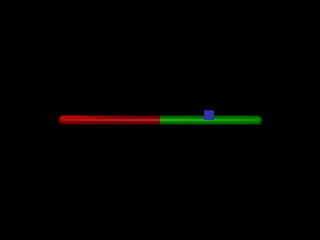

In [3]:
planar_arm = '''
<mujoco>
  <option timestep="0.001" gravity="0 0 -9.81">
    <flag contact="enable"/>
  </option>
  
  <default>
    <geom type="capsule" size="0.05"/>
    <joint type="hinge" axis="0 0 1"/>
  </default>

  <worldbody>
    <!-- Lighting and camera -->
    <light pos="0 -0.4 1"/>
    <camera name="fixed" pos="1 -3 0" xyaxes="1 0 0 0 0 1"/>
    
    <!-- Arm base -->
    <body name="base" pos="0 0 0">
      <!-- First link -->
      <body name="link1" pos="0 0 0">
        <joint name="joint1"/>
        <geom fromto="0 0 0 1 0 0" rgba="1 0 0 1"/>
        
        <!-- Second link -->
        <body name="link2" pos="1 0 0">
          <joint name="joint2"/>
          <geom fromto="0 0 0 1 0 0" rgba="0 1 0 1"/>
        </body>
      </body>
    </body>

    <!-- Static block -->
    <body name="block" pos="1.5 0 0.05">
      <geom type="box" size="0.05 0.05 0.05" rgba="0 0 1 1" density="1000" friction="1 0.5 0.5"/>
    </body>
  </worldbody>

  <actuator>
    <motor joint="joint1" gear="1"/>
    <motor joint="joint2" gear="1"/>
  </actuator>
</mujoco>
'''
model = mujoco.MjModel.from_xml_string(planar_arm)
data = mujoco.MjData(model)
height = 240
width = 320

with mujoco.Renderer(model, height, width) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data, camera="fixed")

  media.show_image(renderer.render())

# For Ubuntu

In [8]:
# import robosuite as suite
# import numpy as np

# # Create environment with Franka rob1t
# env = suite.make(
#     env_name="Lift",
#     robots="Panda",
#     has_renderer=True,
#     has_offscreen_renderer=False,
#     use_camera_obs=False
# )

# # Reset the environment
# obs = env.reset()
# env.render()  # Render the initial state

# # Get cube position from observation
# cube_pos = obs['cube_pos']
# print("Cube position:", cube_pos)

# # Define target positions for lifting the cube:
# # Stage 1: Move above the cube
# above_cube_pos = cube_pos.copy()
# above_cube_pos[2] += 0.1  # Position 10cm above the cube

# # Stage 2: Move down to grasp the cube
# grasp_pos = cube_pos.copy()
# grasp_pos[2] -= 0.01  # Move slightly down to grasp

# # Stage 3: Lift the cube
# lift_pos = cube_pos.copy()
# lift_pos[2] += 0.5  # Lift 20cm above the table
# #lift_pos[0] += 0.5  # Lift 20cm above the table

# print(f"Above cube target: {above_cube_pos}")
# print(f"Grasp position: {grasp_pos}")
# print(f"Lift position: {lift_pos}")

# # Control gains
# kp = 5.0  # Position gain
# gripper_close_steps = 50  # Steps over which to close gripper gradually
# kd = 1.0  # Velocity gain

# # Run the simulation
# done = False
# step_count = 0
# max_steps = 500
# current_stage = 1
# grasped = False


# while step_count < max_steps:
#     current_eef = obs['robot0_eef_pos']
#     current_cube_pos = obs['cube_pos']

#     # Determine target
#     if current_stage == 1:
#         target = above_cube_pos
#         if np.linalg.norm(current_eef - target) < 0.02:
#             current_stage = 2
#             print("Above cube reached, moving to grasp")
#     elif current_stage == 2:
#         target = grasp_pos
#         if np.linalg.norm(current_eef - target) < 0.01:
#             current_stage = 3
#             print("ready to grasp")
#     elif current_stage == 3:
#         target = grasp_pos
#         if action[-1] > 0.5:
#             grasped = True
#         if np.linalg.norm(current_eef - target) < 0.01 and grasped:
#             current_stage = 4 
#             print("Cube grasped, lifting")
#     else:
#         target = lift_pos
#         if np.linalg.norm(current_cube_pos - target) < 0.01:
#             print("Cube lifted successfully!, current_cube_pos:", current_cube_pos, ", target:", target, ", current_stage:", current_stage)
#             break

#     # Compute simple proportional action in end-effector space
#     action = np.zeros(env.action_dim)
#     if current_stage <= 2:
#         action[:3] = kp * (target - current_eef)  # x,y,z
#         action[3:6] = 0.0  # no rotation change
#     else:
#         action[:3] = kp * (target - current_cube_pos)  # x,y,z
#         action[3:6] = 0.0  # no rotation change
#     # Gripper control
#     if current_stage <= 2:
#         action[-1] = -1.0  # open
#     else:
#         # Gradually close over first gripper_close_steps
#         action[-1] = min(1.0, (step_count % gripper_close_steps) / gripper_close_steps)

#     # Step environment
#     obs, reward, done, info = env.step(action)
#     env.render()
#     time.sleep(0.01)
#     step_count += 1

# print("cube_pos:", current_cube_pos, "current_eef:", current_eef, ", target:", target, ", current_stage:", current_stage)
# env.close()
# print("Simulation finished")

# For macOS

In [7]:
import robosuite as suite
import numpy as np
import imageio

# Create environment with Franka rob1t
env = suite.make(
    env_name="Lift",
    robots="Panda",
    has_renderer=False,
    has_offscreen_renderer=True,
    use_camera_obs=False
)

# Reset the environment
obs = env.reset()

# Get cube position from observation
cube_pos = obs['cube_pos']
print("Cube position:", cube_pos)

# Define target positions for lifting the cube:
# Stage 1: Move above the cube
above_cube_pos = cube_pos.copy()
above_cube_pos[2] += 0.1  # Position 10cm above the cube

# Stage 2: Move down to grasp the cube
grasp_pos = cube_pos.copy()
grasp_pos[2] -= 0.01  # Move slightly down to grasp

# Stage 3: Lift the cube
lift_pos = cube_pos.copy()
lift_pos[2] += 0.5  # Lift 20cm above the table
#lift_pos[0] += 0.5  # Lift 20cm above the table

print(f"Above cube target: {above_cube_pos}")
print(f"Grasp position: {grasp_pos}")
print(f"Lift position: {lift_pos}")

# Control gains
kp = 5.0  # Position gain
gripper_close_steps = 50  # Steps over which to close gripper gradually
kd = 1.0  # Velocity gain

# Run the simulation
done = False
step_count = 0
max_steps = 500
current_stage = 1
grasped = False

frames = []
while step_count < max_steps:
    current_eef = obs['robot0_eef_pos']
    current_cube_pos = obs['cube_pos']

    # Determine target
    if current_stage == 1:
        target = above_cube_pos
        if np.linalg.norm(current_eef - target) < 0.02:
            current_stage = 2
            print("Above cube reached, moving to grasp")
    elif current_stage == 2:
        target = grasp_pos
        if np.linalg.norm(current_eef - target) < 0.01:
            current_stage = 3
            print("ready to grasp")
    elif current_stage == 3:
        target = grasp_pos
        if action[-1] > 0.5:
            grasped = True
        if np.linalg.norm(current_eef - target) < 0.01 and grasped:
            current_stage = 4 
            print("Cube grasped, lifting")
    else:
        target = lift_pos
        if np.linalg.norm(current_cube_pos - target) < 0.01:
            print("Cube lifted successfully!, current_cube_pos:", current_cube_pos, ", target:", target, ", current_stage:", current_stage)
            break

    # Compute simple proportional action in end-effector space
    action = np.zeros(env.action_dim)
    if current_stage <= 2:
        action[:3] = kp * (target - current_eef)  # x,y,z
        action[3:6] = 0.0  # no rotation change
    else:
        action[:3] = kp * (target - current_cube_pos)  # x,y,z
        action[3:6] = 0.0  # no rotation change
    # Gripper control
    if current_stage <= 2:
        action[-1] = -1.0  # open
    else:
        # Gradually close over first gripper_close_steps
        action[-1] = min(1.0, (step_count % gripper_close_steps) / gripper_close_steps)

    # Step environment
    obs, reward, done, info = env.step(action)
    # Render offscreen frame
    frame = env.sim.render(camera_name="frontview", width=640, height=480)
    frame = np.flip(frame, axis=0)
    frames.append(frame)

    time.sleep(0.01)
    step_count += 1

print("cube_pos:", current_cube_pos, "current_eef:", current_eef, ", target:", target, ", current_stage:", current_stage)
env.close()
print("Simulation finished")
imageio.mimwrite("lift_cube.mp4", frames, fps=30)
print("Video saved!")

[robosuite INFO] Loading controller configuration from: /opt/miniconda3/envs/mujoco-env/lib/python3.10/site-packages/robosuite/controllers/config/robots/default_panda.json (composite_controller_factory.py:121)
[robosuite INFO] Loading controller configuration from: /opt/miniconda3/envs/mujoco-env/lib/python3.10/site-packages/robosuite/controllers/config/robots/default_panda.json (composite_controller_factory.py:121)


Cube position: [0.03  0.012 0.831]
Above cube target: [0.03  0.012 0.931]
Grasp position: [0.03  0.012 0.821]
Lift position: [0.03  0.012 1.331]
Above cube reached, moving to grasp
ready to grasp
Cube grasped, lifting
Cube lifted successfully!, current_cube_pos: [0.029 0.011 1.321] , target: [0.03  0.012 1.331] , current_stage: 4
cube_pos: [0.029 0.011 1.321] current_eef: [0.026 0.012 1.33 ] , target: [0.03  0.012 1.331] , current_stage: 4
Simulation finished
Video saved!
